In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras import optimizers

from sklearn.model_selection import train_test_split

In [46]:
X=np.load("data/X.npy")
y=np.load("data/Y.npy")

In [47]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validation Accuracy"]=modelHistory.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(12,8))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    plt.show()

In [48]:
from keras.callbacks import EarlyStopping
def split_dataset(X, y, test_size=0.3, random_state=42):
    X_conv=X.reshape(X.shape[0], X.shape[1], X.shape[2],1)
    
    

    return train_test_split(X_conv,y, stratify=y,test_size=test_size,random_state=random_state)

def evaluate_conv_model(model, model_name, X, y, epochs=100,
                        optimizer=optimizers.RMSprop(lr=0.0001), callbacks=None):
    print("[INFO]:Convolutional Model {} created...".format(model_name))
    X_train, X_test, y_train, y_test = split_dataset(X, y)
    
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    print("[INFO]:Convolutional Model {} compiled...".format(model_name))
    
    print("[INFO]:Convolutional Model {} training....".format(model_name))
    earlyStopping = EarlyStopping(monitor = 'val_loss', patience=20, verbose = 1) 
    if callbacks is None:
        callbacks = [earlyStopping]
    modelHistory=model.fit(X_train, y_train, 
             validation_data=(X_test, y_test),
             callbacks=callbacks,
             epochs=epochs,
             verbose=0)
    print("[INFO]:Convolutional Model {} trained....".format(model_name))

    test_scores=model.evaluate(X_test, y_test, verbose=0)
    train_scores=model.evaluate(X_train, y_train, verbose=0)
    print("[INFO]:Train Accuracy:{:.3f}".format(train_scores[1]))
    print("[INFO]:Validation Accuracy:{:.3f}".format(test_scores[1]))
    
    show_model_history(modelHistory=modelHistory, model_name=model_name)
    return model

In [49]:
def decode_OneHotEncoding(label):
    label_new=list()
    for target in label:
        label_new.append(np.argmax(target))
    label=np.array(label_new)
    
    return label
def correct_mismatches(label):
    label_map={0:9,1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
    label_new=list()
    for s in label:
        label_new.append(label_map[s])
    label_new=np.array(label_new)
    
    return label_new
    
def show_image_classes(image, label, n=10):
    label=decode_OneHotEncoding(label)
    label=correct_mismatches(label)
    fig, axarr=plt.subplots(nrows=n, ncols=n, figsize=(18, 18))
    axarr=axarr.flatten()
    plt_id=0
    start_index=0
    for sign in range(10):
        sign_indexes=np.where(label==sign)[0]
        for i in range(n):

            image_index=sign_indexes[i]
            axarr[plt_id].imshow(image[image_index], cmap='gray')
            axarr[plt_id].set_xticks([])
            axarr[plt_id].set_yticks([])
            axarr[plt_id].set_title("Sign :{}".format(sign))
            plt_id=plt_id+1
    plt.suptitle("{} Sample for Each Classes".format(n))
    plt.show()

In [50]:
number_of_pixels=X.shape[1]*X.shape[2]
number_of_classes=y.shape[1]
print(20*"*", "SUMMARY of the DATASET",20*"*")
print("an image size:{}x{}".format(X.shape[1], X.shape[2]))
print("number of pixels:",number_of_pixels)
print("number of classes:",number_of_classes)

y_decoded=decode_OneHotEncoding(y.copy())
sample_per_class=np.unique(y_decoded, return_counts=True)
print("Number of Samples:{}".format(X.shape[0]))
for sign, number_of_sample in zip(sample_per_class[0], sample_per_class[1]):
    print("  {} sign has {} samples.".format(sign, number_of_sample))
print(65*"*")

******************** SUMMARY of the DATASET ********************
an image size:64x64
number of pixels: 4096
number of classes: 10
Number of Samples:2062
  0 sign has 204 samples.
  1 sign has 205 samples.
  2 sign has 206 samples.
  3 sign has 207 samples.
  4 sign has 206 samples.
  5 sign has 208 samples.
  6 sign has 207 samples.
  7 sign has 206 samples.
  8 sign has 206 samples.
  9 sign has 207 samples.
*****************************************************************


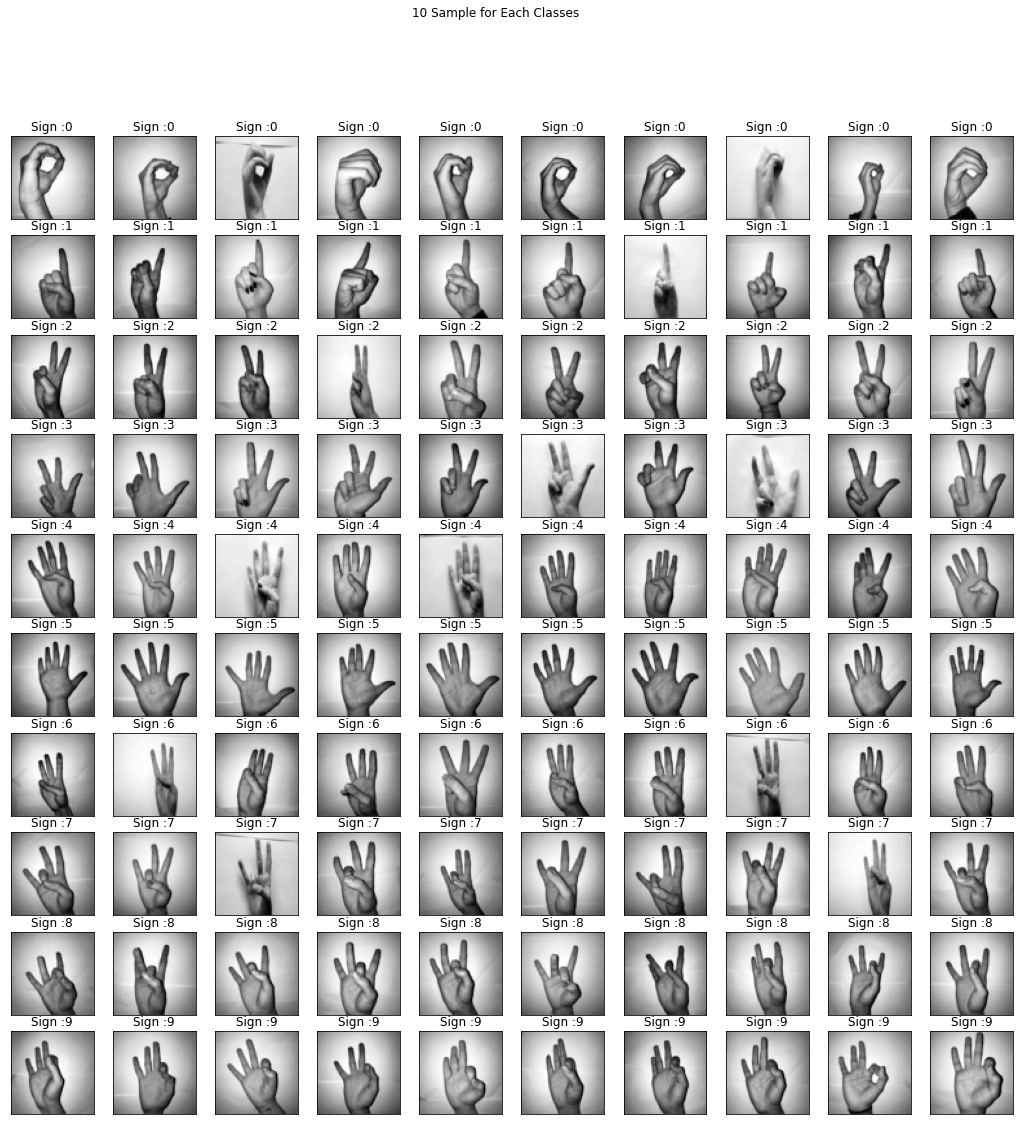

In [51]:
show_image_classes(image=X, label=y.copy())

In [52]:
def build_conv_model_1():
    model=Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=(3,3),
                           padding="same",
                           activation="relu", 
                           input_shape=(64, 64,1)))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(number_of_classes, activation="softmax"))
        
    return model

[INFO]:Convolutional Model 1 created...
[INFO]:Convolutional Model 1 compiled...
[INFO]:Convolutional Model 1 training....
[INFO]:Convolutional Model 1 trained....
[INFO]:Train Accuracy:0.650
[INFO]:Validation Accuracy:0.599


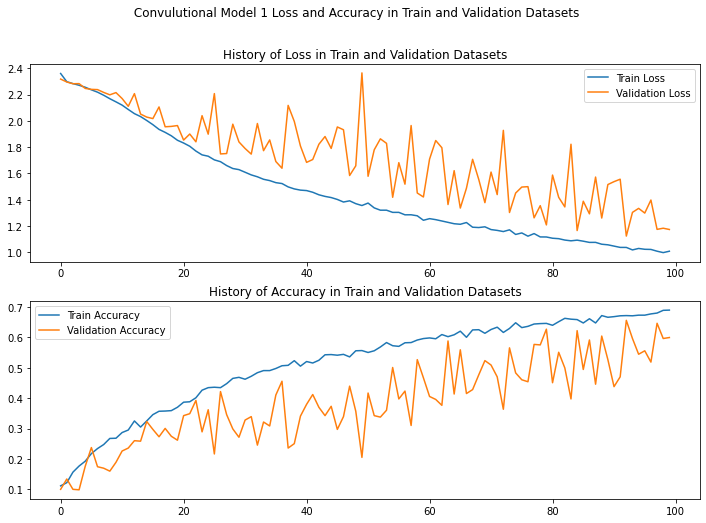

In [53]:
trained_models=dict()
model=build_conv_model_1()
trained_model_1=evaluate_conv_model(model=model, model_name=1, X=X, y=y)

#Will be used for serialization
trained_models["model_1"]=(trained_model_1,optimizers.RMSprop(lr=0.0001) )